### Import Library

In [1]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.utils import shuffle
from datetime import datetime
from collections import Counter
from scipy.stats import  ks_2samp, chi2_contingency
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization  

import nest_asyncio
nest_asyncio.apply()

# تنظیم بذر تصادفی برای تکرارپذیری
np.random.seed(42)

C:\Users\TOP\anaconda3\envs\evn8\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.18.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Create Model 

In [2]:
# تابع ساخت مدل MLP
def create_mnist_mlp_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,)))
    # model.add(Dropout(0.5))
    model.add(BatchNormalization())  
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax')) 
    optimizer = Adam(learning_rate=0.01)
    return model

### Load and Split

In [3]:
# لود کردن داده‌های MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# ترکیب داده‌ها و برچسب‌ها برای شافل کردن با zip
combined = list(zip(x_train, y_train))

# شافل کردن داده‌ها
np.random.shuffle(combined)

# جداسازی داده‌ها و برچسب‌ها پس از شافل
x_train, y_train = zip(*combined)

# تبدیل به آرایه numpy
x_train = np.array(x_train)
y_train = np.array(y_train)

# شافل کردن داده‌ها
# x_train, y_train = shuffle(x_train, y_train)

# نرمال‌سازی داده‌ها
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# مسطح کردن تصاویر
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# کدگذاری لیبل‌ها
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# تقسیم داده‌ها بین کلاینت ها
num_clients =5
client_data = np.array_split(x_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

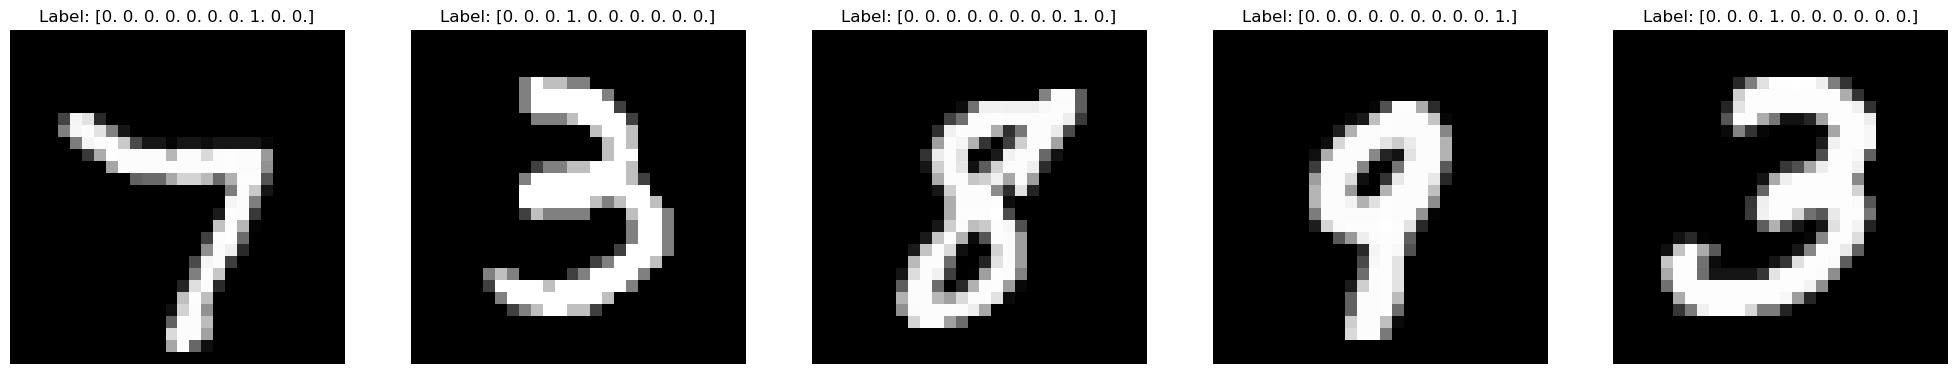

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 5))  # اندازه‌ی بزرگتر برای وضوح بیشتر
for i in range(5):
    plt.subplot(1, 5, i+1)  # 1 سطر و 5 ستون برای نمایش 5 تصویر
    image = x_train[i].reshape(28, 28)  # تغییر ابعاد به 28x28 برای نمایش تصویر
    plt.imshow(image, cmap='gray')  # فرض می‌کنیم که داده‌ها به صورت grayscale هستند
    plt.title(f"Label: {y_train[i]}")  # نمایش لیبل به صورت عددی (مثلاً 4 به جای [0,0,0,0,1])
    plt.axis('off')  # خاموش کردن محورهای نمودار
plt.show()

### Bug Injection

In [5]:
# random.seed(10)
# # تعداد کلاینت‌ها را مشخص کنید
# num_clients = len(client_data)

# # انتخاب تصادفی یک کلاینت
# # clients_to_double_normalize = [random.randint(0, num_clients - 1)]

# # نسبت انتخاب کلاینت‌ها (به صورت کسری)
# fraction_to_select = 0.25

# # تعداد کلاینت‌هایی که باید انتخاب شوند
# num_clients_to_select = int(fraction_to_select * num_clients)

# # انتخاب تصادفی کلاینت‌ها
# clients_to_double_normalize = random.sample(range(num_clients), num_clients_to_select)

# # چاپ کلاینت‌های انتخاب‌شده
# print(f"Number of selected clients: {len(clients_to_double_normalize)}")

# print("Selected clients for double normalization:", clients_to_double_normalize)

# # دوبار نرمال‌سازی کلاینت‌های مشخص‌شده
# for client_index in clients_to_double_normalize:
#     client_data[client_index] = client_data[client_index] / 255.0

### Bugless

In [6]:
# لیستی از کلاینت‌هایی که باید دوبار نرمال‌سازی شوند
clients_to_double_normalize = []  

# دوبار نرمال‌سازی کلاینت‌های مشخص‌شده
for client_index in clients_to_double_normalize:
    client_data[client_index] = client_data[client_index] / 255.0

# پوشه‌ای برای ذخیره پارامترهای کلاینت‌ها ایجاد می‌کنیم
if not os.path.exists('client_params'):
    os.makedirs('client_params')

### Models training & save

In [7]:
# آموزش مدل‌ها برای هر کلاینت و ذخیره پارامترها
client_models = [] #لیست برای ذخیره مدل‌های هر کلاینت
client_accuracies = []  # لیست برای ذخیره دقت آموزش هر کلاینت

base_model = create_mnist_mlp_model()  # مدل پایه
base_model.save_weights('base_model_weights.h5') # ذخیره وزن‌های مدل پایه

# آموزش مدل برای هر کلاینت
for i in range(num_clients):
    print(f"Training model for client {i}")    
    model = create_mnist_mlp_model()
    model.set_weights(base_model.get_weights())  # بارگذاری وزن‌های مدل پایه برای هر کلاینت
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # آموزش مدل و ذخیره دقت برای کلاینت
    history = model.fit(client_data[i], client_labels[i], epochs=10, batch_size=32, verbose=1)
    accuracy = history.history['accuracy'][-1]  # دقت آموزش آخرین ایپوک
    client_accuracies.append(f"Client {i} Training Accuracy: {accuracy:.4f}")
    
    client_models.append(model)  # افزودن مدل به لیست
print("Training completed for all clients.")

Training model for client 0
Epoch 1/10
375/375 [==============================] - 1s 2ms/step - loss: 0.4001 - accuracy: 0.8798
Epoch 2/10
375/375 [==============================] - 1s 2ms/step - loss: 0.1645 - accuracy: 0.9500
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1130 - accuracy: 0.9655
Epoch 4/10
375/375 [==============================] - 1s 2ms/step - loss: 0.0805 - accuracy: 0.9756
Epoch 5/10
375/375 [==============================] - 1s 2ms/step - loss: 0.0638 - accuracy: 0.9794
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0498 - accuracy: 0.9826
Epoch 7/10
375/375 [==============================] - 1s 2ms/step - loss: 0.0435 - accuracy: 0.9860
Epoch 8/10
375/375 [==============================] - 1s 2ms/step - loss: 0.0332 - accuracy: 0.9897
Epoch 9/10
375/375 [==============================] - 1s 2ms/step - loss: 0.0367 - accuracy: 0.9884
Epoch 10/10
375/375 [==============================] - 1s 2ms/step - los

### Class

In [8]:
def delta_class(models, x_test):
    num_models = len(models)
    argmax_preds = [model.predict(x_test).argmax(axis=1) for model in models]   # پیش‌بینی‌ها برای هر مدل
    diffs_matrix = np.zeros((num_models, num_models), dtype=int)    # ماتریس مربعی برای ذخیره تفاوت‌ها
    for i in range(num_models):       # پر کردن ماتریس با تفاوت پیش‌بینی‌ها
        for j in range(i+1, num_models):
            diffs = np.sum(argmax_preds[i] != argmax_preds[j])  # تعداد تفاوت‌های پیش‌بینی بین مدل i و مدل j
            diffs_matrix[i, j] = diffs
            diffs_matrix[j, i] = diffs  # ماتریس متقارن است
    return diffs_matrix


diff_class = delta_class(client_models, x_test)
print("Difference Matrix for Delta Class:")
print(diff_class)

Difference Matrix for Delta Class:
[[  0 479 511 449 474]
 [479   0 507 434 478]
 [511 507   0 514 547]
 [449 434 514   0 439]
 [474 478 547 439   0]]


### Score

In [9]:
def delta_score(models, x_test, threshold):
    num_models = len(models)
    diffs_matrix = np.zeros((num_models, num_models))

    # پیش‌بینی خروجی‌های هر مدل
    predictions = [model.predict(x_test) for model in models]
    
    # محاسبه‌ی argmax برای هر مدل
    argmax_preds = [np.argmax(pred, axis=1) for pred in predictions]

    # مقایسه مدل‌ها دو به دو
    for i in range(num_models):
        for j in range(i + 1, num_models):
            diff_count = 0  # شمارنده اختلافات

            # مقایسه‌ی argmax ها
            argmax_diff = argmax_preds[i] != argmax_preds[j]
            diff_count += np.sum(argmax_diff)  # اضافه کردن اختلاف در argmax
            
            # مقایسه‌ی احتمالات برای پیش‌بینی‌های با argmax یکسان
            same_argmax_indices = np.where(argmax_preds[i] == argmax_preds[j])[0]
            
            for idx in same_argmax_indices:
                # مقایسه‌ی احتمالات در همان کلاس‌های argmax
                prob_i = round(predictions[i][idx][argmax_preds[i][idx]],3)
                prob_j = round(predictions[j][idx][argmax_preds[j][idx]],3)
                                
                # محاسبه اختلاف بین پیش‌بینی‌ها
                prob_diff = abs(prob_i - prob_j)
               
                # بررسی اختلاف با آستانه threshold
                if prob_diff >= threshold:
                    diff_count += 1  # شمارش اختلاف در پیش‌بینی‌ها

            # ذخیره اختلافات در هر دو موقعیت (i, j) و (j, i) برای متقارن بودن
            diffs_matrix[i, j] = diff_count
            diffs_matrix[j, i] = diff_count

    return diffs_matrix

# اجرای تابع با تعیین آستانه threshold
diff_score = delta_score(client_models, x_test, threshold=0.1)
print("Distance Matrix for Delta Score:")
print(diff_score)

Distance Matrix for Delta Score:
[[   0.  988. 1073.  927.  982.]
 [ 988.    0. 1064.  929. 1022.]
 [1073. 1064.    0. 1043. 1106.]
 [ 927.  929. 1043.    0.  952.]
 [ 982. 1022. 1106.  952.    0.]]


### KS

In [10]:
def ks(models, x_test):
    num_samples = x_test.shape[0]
    num_models = len(models)

    # مرحله 1: پیش‌بینی کلاس‌ها برای داده‌های تست توسط هر مدل
    argmax_preds = np.array([model.predict(x_test).argmax(axis=1) for model in client_models])

    # مرحله 2: یافتن کلاس پرتکرار برای هر نمونه
    most_frequent_classes = [Counter(argmax_preds[:, i]).most_common(1)[0][0] for i in range(num_samples)]

    # مرحله 3: استخراج احتمال کلاس پرتکرار از تمامی مدل‌ها برای هر نمونه
    all_probabilities = np.zeros((num_samples, num_clients))
    for i, model in enumerate(client_models):
        predictions = model.predict(x_test)  # احتمالات کلاس‌های مختلف برای هر نمونه
        for j, sample in enumerate(x_test):
            most_frequent_class = most_frequent_classes[j]
            all_probabilities[j, i] = predictions[j, most_frequent_class]  # احتمال کلاس پرتکرار
    # مرحله 4: انجام تست KS بین مدل‌های کلاینت و ایجاد ماتریس KS
    ks_distance_matrix = np.zeros((num_clients, num_clients))
    for i in range(num_clients):
        for j in range(i + 1, num_clients):
            # تست KS برای مقایسه احتمالات دو مدل کلاینت
            ks_statistic, _ = ks_2samp(all_probabilities[:, i], all_probabilities[:, j])
            ks_distance_matrix[i, j] = ks_statistic
            ks_distance_matrix[j, i] = ks_statistic  # ماتریس متقارن

    return ks_distance_matrix

# اجرای تابع با تعیین تعداد ارقام اعشار
matrix_ks = ks(client_models, x_test)
print("Distance Matrix for KS:")
print(matrix_ks)

Distance Matrix for KS:
[[0.     0.023  0.0392 0.0246 0.0617]
 [0.023  0.     0.0351 0.019  0.0644]
 [0.0392 0.0351 0.     0.0257 0.0461]
 [0.0246 0.019  0.0257 0.     0.0465]
 [0.0617 0.0644 0.0461 0.0465 0.    ]]


### Chi2

In [11]:
def chi_square(models, x_test):
    num_models = len(models)
    num_samples = x_test.shape[0] # تعداد نمونه‌ها  
    n_classes = 10  # تعداد کلاس ها

    # ساخت ماتریس متقارن برای نتایج Chi-Square
    chi2_matrix = np.zeros((num_models, num_models))
    all_probabilities = np.zeros((num_samples, num_models))

    for i, model in enumerate(models):
        predictions = model.predict(x_test)  # احتمالات کلاس‌های مختلف برای هر نمونه
        for j, sample in enumerate(x_test):
            all_probabilities[j, i] = predictions[j].argmax()

    # مرحله: ایجاد جدول‌های متقاطع و انجام تست Chi-Square
    for i in range(num_models):
        for j in range(i + 1, num_models):
            # ساخت جدول متقاطع
            contingency_table = pd.crosstab(all_probabilities[:, i], all_probabilities[:, j])
            chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
            chi2_matrix[i, j] = chi2_stat
            chi2_matrix[j, i] = chi2_stat  # ماتریس متقارن

    return chi2_matrix

# اجرای تابع با تعیین تعداد ارقام اعشار
matrix_chi2 = chi_square(client_models, x_test)
print("Distance Matrix for Chi square:")
print(matrix_chi2)

Distance Matrix for Chi square:
[[    0.         80622.05117423 80083.7776993  81201.17135377
  80743.1954507 ]
 [80622.05117423     0.         80112.33064614 81474.52551149
  80625.48102528]
 [80083.7776993  80112.33064614     0.         80041.51108519
  79371.5498519 ]
 [81201.17135377 81474.52551149 80041.51108519     0.
  81377.24182738]
 [80743.1954507  80625.48102528 79371.5498519  81377.24182738
      0.        ]]


### The problematic client

In [12]:
def meancal(matrix):
    temp = 0
    x = matrix.shape[0]    
    arrmean = []
    for i in range(0,x):
        temp = (matrix[i].mean())    
        arrmean.append(temp)
    return arrmean

def iqrfunc(nparray):
    data = np.array(nparray)
    q1 = np.percentile(data,25)
    q3 = np.percentile(data,75)
    iqr = q3 -q1
    lower_bound = q1-(iqr*1.5)
    upper_bound = q3+(iqr*1.5)
    outliers = np.where((data<lower_bound) | (data>upper_bound))[0]
    return outliers
    
temp_c = meancal(diff_class)
temp_s = meancal(diff_score)
temp_ks = meancal(matrix_ks)
temp_chi2 = meancal(matrix_chi2)

print(f"Index Problemmatic Clients for Delta class:{iqrfunc(temp_c)}")                       
print(f"Index Problemmatic Clients for Delta Score: {iqrfunc(temp_s)}")                                            
print(f"IndexProblemmatic Clients for KS: {iqrfunc(temp_ks)}")                       
print(f"Index Problemmatic Clients for X2: {iqrfunc(temp_chi2)}") 

Index Problemmatic Clients for Delta class:[2 3]
Index Problemmatic Clients for Delta Score: [2]
IndexProblemmatic Clients for KS: [3 4]
Index Problemmatic Clients for X2: [2 3]


### Save in txt file

In [13]:
changes_dir = 'C:/Users/TOP/Thesis/Last_Code/Log_Changes' # مسیر کامل برای ذخیره‌سازی فایل تغییرات
os.makedirs(changes_dir, exist_ok=True)  # پوشه را ایجاد می‌کند اگر وجود نداشته باشد
log_file_path = os.path.join(changes_dir, 'Seed(42)_Bugless.txt')
def log_change(change_name, description):
    with open(log_file_path, 'a', encoding='utf-8') as log_file:
        log_file.write(f'--- {change_name} ---\n')
        log_file.write(f'Time: {datetime.now()}\n')
        log_file.write(f'Description: {description}\n')
        log_file.write('-----------------------------\n')
accuracy_log = "\n".join(client_accuracies)

changes_description = (
    "Changes Made:\n"
    "1. تعداد کلاینتها 5 \n"
    # "2. (36, 2, 27, 30, 49, 0, 13, 29, 31, 17, 10, 48)اجرا با 25% باگ\n"
    "2. بدون باگ\n"
    "3. round = (_,3) , threshold=0.1 در تابع score\n"
    "4. Model:"
    """
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(784,)))
        # model.add(Dropout(0.5))
        model.add(BatchNormalization())  
        model.add(Dense(128, activation='relu'))
        # model.add(Dropout(0.3))
        model.add(Dense(10, activation='softmax'))  
        optimizer = Adam(learning_rate=0.01)
     """"\n"
    "5. np.random.shuffle(combined)\n"
    # "5. x_train, y_train = shuffle(x_train, y_train)\n" 
    "6. epochs=10, batch_size=32\n"
    "7. np.random.seed(42)"
       )
full_log = (
    f"{changes_description}\n"
    f"Results:\n"
    f"{accuracy_log}\n\n"
    f"Index Problemmatic Clients for Delta class: {iqrfunc(temp_c)}\n"
    f"Index Problemmatic Clients for Delta Score: {iqrfunc(temp_s)}\n"
    f"Index Problemmatic Clients for KS: {iqrfunc(temp_ks)}\n"
    f"Index Problemmatic Clients for X2: {iqrfunc(temp_chi2)}\n"   
)

log_change("All changes", full_log)